#### Name:Nadire Waili



In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests as rq
import json
from pandas.io.json import json_normalize
import regex as re
from statsmodels.formula.api import ols

## 1.0 API

#### For API session, I chose the API provided by Electricity Maps. 

They supply information about: 
1.where the electricity in a specific area comes from
2.how much carbon was emitted to produce it

Important Note: The API provides latest 24 hours data for each endpoints(since I required 30 days of free try, I only got 4-5 valuable endpoints, which I will use most of them below). 

I have more interest in where the electricity comes from, especially in discovering how much is the renewable energy such as hydrogen playing a part in it, I will start with analyzing the electricity power breakdown for accessible zones. 

As far as I know, they only allow users to retrive one zone with its individual coordinate(zone) value at a time. However, they provided a google zone overview which I can input as an excel and loop through the zones in it. Below are my specific operations. 

First, I will get a list of zones. 

In [2]:
zone='https://api.electricitymap.org/v3/zones'

In [3]:
api_key='q5ETsZHyJkbwRcvOcHZbIyv2TPc1AU5D'

In [4]:
response = rq.get(zone,api_key) 

In [5]:
response

<Response [200]>

In [6]:
response.json()

{'AD': {'zoneName': 'Andorra'},
 'AE': {'zoneName': 'United Arab Emirates'},
 'AF': {'zoneName': 'Afghanistan'},
 'AG': {'zoneName': 'Antigua and Barbuda'},
 'AL': {'zoneName': 'Albania'},
 'AM': {'zoneName': 'Armenia'},
 'AO': {'zoneName': 'Angola'},
 'AR': {'zoneName': 'Argentina'},
 'AT': {'zoneName': 'Austria'},
 'AU': {'zoneName': 'Australia'},
 'AU-LH': {'countryName': 'Australia', 'zoneName': 'Lord Howe Island'},
 'AU-NSW': {'countryName': 'Australia', 'zoneName': 'New South Wales'},
 'AU-NT': {'countryName': 'Australia', 'zoneName': 'Northern Territory'},
 'AU-QLD': {'countryName': 'Australia', 'zoneName': 'Queensland'},
 'AU-SA': {'countryName': 'Australia', 'zoneName': 'South Australia'},
 'AU-TAS': {'countryName': 'Australia', 'zoneName': 'Tasmania'},
 'AU-TAS-CBI': {'countryName': 'Australia', 'zoneName': 'Cape Barren Island'},
 'AU-TAS-FI': {'countryName': 'Australia', 'zoneName': 'Flinders Island'},
 'AU-TAS-KI': {'countryName': 'Australia', 'zoneName': 'King Island'},
 '

Above I just retrieved the json as a cursory glance at the area.
Below I copied their area Excel sheet and input it into the loop.

In [7]:
file_path='http://localhost:8888/edit/Downloads/zone_list.xlsx'

In [8]:
file_path = '/Users/nadira/Downloads/zone_list.xlsx'
zone_list = pd.read_excel(file_path)
zone_list


,Electricity Maps Zone Key,NameElectricity Maps Zone Name,Country
0,AT,Austria,Austria
1,AU-NSW,New South Wales,Australia
2,AU-NT,Northern Territory,Australia
3,AU-QLD,Queensland,Australia
4,AU-SA,South Australia,Australia
...,...,...,...
141,US-SW-WALC,Western Area Power Administration - Desert Sou...,USA
142,US-TEN-TVA,Tennessee Valley Authority,USA
143,US-TEX-ERCO,"Electric Reliability Council Of Texas, Inc.",USA
144,UY,Uruguay,Uruguay


In [9]:
zones=zone_list['Electricity Maps Zone Key']
zones

0               AT
1           AU-NSW
2            AU-NT
3           AU-QLD
4            AU-SA
          ...     
141     US-SW-WALC
142     US-TEN-TVA
143    US-TEX-ERCO
144             UY
145             ZA
Name: Electricity Maps Zone Key, Length: 146, dtype: object



### Data for all available zones:

In [10]:
# Input zones from the list as params
url = 'https://api-access.electricitymaps.com/2w97h07rvxvuaa1g/power-breakdown/latest'
headers = {'auth-token':'Pce68mLxzrDVZFRvNQfZ87aBeoNmKjpo'}

responses=[]
for zone in zones: 
    params={'zone':zone}
    response_6=rq.get(url,headers=headers,params=params)
    responses.append(response_6.json())
    
responses

[{'zone': 'AT',
  'datetime': '2024-05-03T16:00:00.000Z',
  'updatedAt': '2024-05-03T16:48:28.217Z',
  'createdAt': '2024-04-30T16:50:05.097Z',
  'powerConsumptionBreakdown': {'nuclear': 0,
   'geothermal': 0,
   'biomass': 301,
   'coal': 0,
   'wind': 500,
   'solar': 690,
   'hydro': 3746,
   'gas': 72,
   'oil': 0,
   'unknown': 18,
   'hydro discharge': 857,
   'battery discharge': 0},
  'powerProductionBreakdown': {'nuclear': None,
   'geothermal': 0,
   'biomass': 376,
   'coal': 0,
   'wind': 625,
   'solar': 863,
   'hydro': 4684,
   'gas': 90,
   'oil': 0,
   'unknown': 22,
   'hydro discharge': 1071,
   'battery discharge': None},
  'powerImportBreakdown': {'DE': 0, 'HU': 0},
  'powerExportBreakdown': {'DE': 1007, 'HU': 541},
  'fossilFreePercentage': 99,
  'renewablePercentage': 99,
  'powerConsumptionTotal': 6183,
  'powerProductionTotal': 7731,
  'powerImportTotal': 0,
  'powerExportTotal': 1548,
  'isEstimated': True,
  'estimationMethod': 'TIME_SLICER_AVERAGE'},
 {'zone

In [11]:
len(responses)

146

Above, we can clearly see currently there is available data for 146 zones.
Next, Since I am mostly interested in 'powerConsumptionBreakdown', I will make a dataframe of this nested list. 

In [12]:
consumption_data = []

for response in responses:
    try:
        b = response['zone']
        c = response['powerConsumptionBreakdown']
        consumption_data.append((b, c))
        print(consumption_data)
        
    except:
        print('error')


[('AT', {'nuclear': 0, 'geothermal': 0, 'biomass': 301, 'coal': 0, 'wind': 500, 'solar': 690, 'hydro': 3746, 'gas': 72, 'oil': 0, 'unknown': 18, 'hydro discharge': 857, 'battery discharge': 0})]
[('AT', {'nuclear': 0, 'geothermal': 0, 'biomass': 301, 'coal': 0, 'wind': 500, 'solar': 690, 'hydro': 3746, 'gas': 72, 'oil': 0, 'unknown': 18, 'hydro discharge': 857, 'battery discharge': 0}), ('AU-NSW', {'nuclear': 0, 'geothermal': 0, 'biomass': 35, 'coal': 5471, 'wind': 1318, 'solar': 0, 'hydro': 306, 'gas': 32, 'oil': 0, 'unknown': 0, 'hydro discharge': 0, 'battery discharge': 0})]
[('AT', {'nuclear': 0, 'geothermal': 0, 'biomass': 301, 'coal': 0, 'wind': 500, 'solar': 690, 'hydro': 3746, 'gas': 72, 'oil': 0, 'unknown': 18, 'hydro discharge': 857, 'battery discharge': 0}), ('AU-NSW', {'nuclear': 0, 'geothermal': 0, 'biomass': 35, 'coal': 5471, 'wind': 1318, 'solar': 0, 'hydro': 306, 'gas': 32, 'oil': 0, 'unknown': 0, 'hydro discharge': 0, 'battery discharge': 0}), ('AU-NT', {'nuclear': 0, 

In [13]:
consumptiondf= pd.DataFrame(consumption_data, columns=['zone','powerconsumptionBreakdown'])
df_breakdown = pd.json_normalize(consumptiondf['powerconsumptionBreakdown'])
consumption_df_1 = pd.concat([consumptiondf['zone'], df_breakdown], axis=1)

In [14]:
consumption_df_1

,zone,nuclear,geothermal,biomass,coal,wind,solar,hydro,gas,oil,unknown,hydro discharge,battery discharge
0,AT,0,0,301,0,500,690,3746,72,0,18,857,0
1,AU-NSW,0,0,35,5471,1318,0,306,32,0,0,0,0
2,AU-NT,0,0,1,0,0,0,0,144,0,0,0,0
3,AU-QLD,0,0,20,4742,641,0,79,68,0,0,0,0
4,AU-SA,0,0,0,424,579,0,11,405,0,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,US-SW-WALC,0,0,0,0,12,120,530,495,0,0,0,0
142,US-TEN-TVA,7286,0,0,2333,15,551,1050,6652,9,313,0,0
143,US-TEX-ERCO,3688,0,0,5199,9257,10413,107,24280,0,123,0,0
144,UY,0,0,157,0,346,205,1038,0,0,0,0,0


In the following, by classifying zones into different regions, I wish to see what are the differences of consumption breakdown while investigating from different regions(continents).

In [15]:
def classify_zone(zone):
    if 'US' in zone:
        return 'US'
    elif 'AU' in zone:
        return 'Australia'
    elif 'JP' in zone or 'TW' in zone:
        return 'Asia'
    elif 'BR' in zone or 'PA' in zone or 'CR' in zone:
        return 'Latin America'
    elif ('AT' in zone or 'DK' in zone or 'CY' in zone or 'GB' in zone or 'GR' in zone
        or 'IT' in zone or 'NL' in zone or 'NO' in zone or 'PL' in zone
        or 'PT' in zone or 'SE' in zone):
        return 'European Union'
    else:
        return 'Other Zones'


In [16]:
Region=consumption_df_1['zone'].apply(classify_zone)

In [17]:
region_df = pd.DataFrame({'region': Region})

In [18]:
consumption_df = pd.concat([consumption_df_1, region_df], axis=1)
consumption_df

,zone,nuclear,geothermal,biomass,coal,wind,solar,hydro,gas,oil,unknown,hydro discharge,battery discharge,region
0,AT,0,0,301,0,500,690,3746,72,0,18,857,0,European Union
1,AU-NSW,0,0,35,5471,1318,0,306,32,0,0,0,0,Australia
2,AU-NT,0,0,1,0,0,0,0,144,0,0,0,0,Australia
3,AU-QLD,0,0,20,4742,641,0,79,68,0,0,0,0,Australia
4,AU-SA,0,0,0,424,579,0,11,405,0,0,0,17,Australia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,US-SW-WALC,0,0,0,0,12,120,530,495,0,0,0,0,US
142,US-TEN-TVA,7286,0,0,2333,15,551,1050,6652,9,313,0,0,US
143,US-TEX-ERCO,3688,0,0,5199,9257,10413,107,24280,0,123,0,0,US
144,UY,0,0,157,0,346,205,1038,0,0,0,0,0,Other Zones


In [19]:
US_breakdown = consumption_df[consumption_df['region'] == 'US']
EU_breakdown=consumption_df[consumption_df['region'] == 'European Union']
Asia_breakdown=consumption_df[consumption_df['region'] == 'Asia']
Latin_America =consumption_df[consumption_df['region'] == 'Latin America']
Other_zones=consumption_df[consumption_df['region'] == 'Other Zones']

In [20]:
# Display example:
Asia_breakdown

,zone,nuclear,geothermal,biomass,coal,wind,solar,hydro,gas,oil,unknown,hydro discharge,battery discharge,region
51,JP-CB,963,0,128,2913,10,0,945,3268,310,31,0,0,Asia
52,JP-CG,221,1,142,1555,11,0,328,1746,155,4,0,0,Asia
53,JP-HKD,0,6,160,770,86,0,281,865,76,0,0,0,Asia
54,JP-HR,0,0,43,608,4,0,449,671,85,39,0,0,Asia
55,JP-KN,6828,0,39,2333,8,0,876,2572,325,150,0,0,Asia
56,JP-KY,3083,81,262,1291,49,0,283,1456,126,0,0,0,Asia
57,JP-ON,0,0,35,336,1,0,1,377,33,0,0,0,Asia
58,JP-TH,0,69,263,2241,112,0,772,2472,311,141,0,0,Asia
59,JP-TK,78,33,429,11605,88,0,1767,13044,1178,69,899,0,Asia
89,TW,1877,2,21,9005,1254,0,232,12163,201,585,0,0,Asia


As we created Asia_breakdown dataframe, I wish to see how the hydro percentage varies in these areas. So below I got a plot for Asian countries. And for other areas, the operations are similar. 

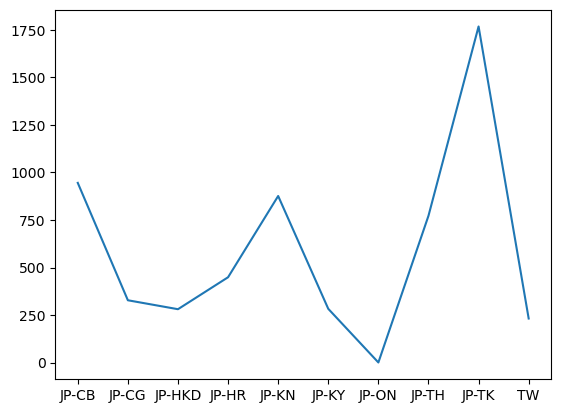

In [55]:
import matplotlib.pyplot as plt
plt.plot(Asia_breakdown['zone'], Asia_breakdown['hydro'])

In the followings, I want to analyze the electricity source percentage for different continents. And Pie chart would help create plots for conparison. Since there are data for many countries, I use describe mothod to retrieve the mean value for each column, and then use them to represent each continent by getting the pie charts. 

In [22]:
Asia_breakdown.describe()

,nuclear,geothermal,biomass,coal,wind,solar,hydro,gas,oil,unknown,hydro discharge,battery discharge
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,1305.000000,19.200000,152.200000,3265.700000,162.300000,0.0,593.400000,3863.400000,280.000000,101.900000,89.900000,0.0
std,2201.051415,31.208261,132.241194,3847.492547,385.787809,0.0,514.187428,4699.181352,332.753162,178.894413,284.288762,0.0
min,0.000000,0.000000,21.000000,336.000000,1.000000,0.0,1.000000,377.000000,33.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,40.000000,900.250000,8.500000,0.0,281.500000,1012.750000,95.250000,1.000000,0.000000,0.0
50%,149.500000,1.500000,135.000000,1898.000000,30.000000,0.0,388.500000,2109.000000,178.000000,35.000000,0.000000,0.0
75%,1648.500000,26.250000,236.500000,2768.000000,87.500000,0.0,850.000000,3094.000000,310.750000,123.000000,0.000000,0.0
max,6828.000000,81.000000,429.000000,11605.000000,1254.000000,0.0,1767.000000,13044.000000,1178.000000,585.000000,899.000000,0.0


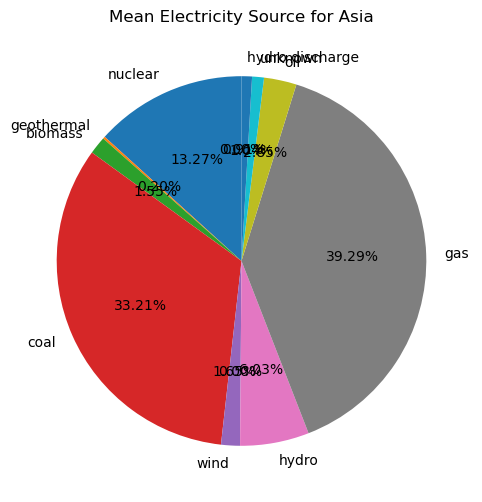

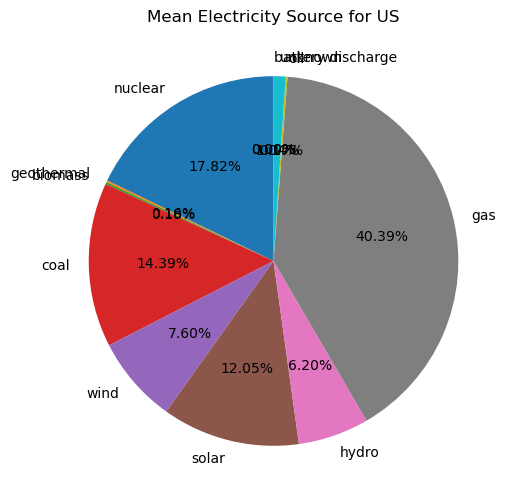

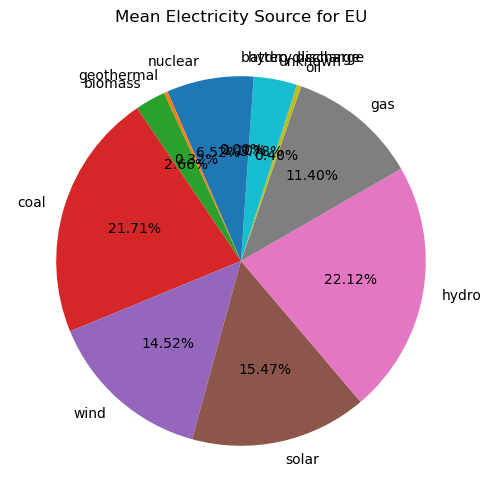

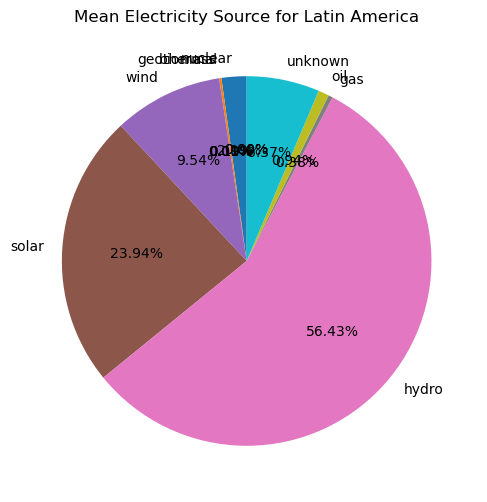

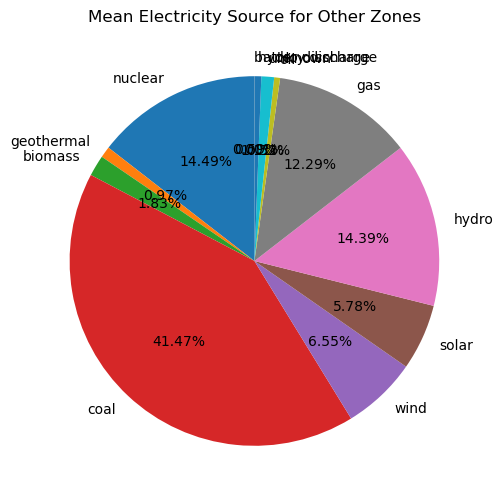

In [23]:
Asia_1=Asia_breakdown.describe()
Asia_1=Asia_1.iloc[1]
plot_Asia=plt.figure(figsize=(6, 6))
Asia_1.plot.pie(autopct='%1.2f%%', label=1, startangle=90)
plt.title('Mean Electricity Source for Asia')
plt.ylabel('')  
plt.show()


US_1=US_breakdown.describe()
US_1=US_1.iloc[1]
plot_US=plt.figure(figsize=(6, 6))
US_1.plot.pie(autopct='%1.2f%%', startangle=90)
plt.title('Mean Electricity Source for US')
plt.ylabel('')  
plt.show()


EU_1=EU_breakdown.describe()
EU_1=EU_1.iloc[1]
plot_EU=plt.figure(figsize=(6, 6))
EU_1.plot.pie(autopct='%1.2f%%', startangle=90)
plt.title('Mean Electricity Source for EU')
plt.ylabel('')  
plt.show()

Latin_America_1=Latin_America.describe()
Latin_America_1=Latin_America_1.iloc[1]
Latin_America_plot=plt.figure(figsize=(6, 6))
Latin_America_1.plot.pie(autopct='%1.2f%%', startangle=90)
plt.title('Mean Electricity Source for Latin America')
plt.ylabel('')  
plt.show()


Others_1=Other_zones.describe()
Others_1=Others_1.iloc[1]
plot_Others=plt.figure(figsize=(6, 6))
Others_1.plot.pie(autopct='%1.2f%%', startangle=90)
plt.title('Mean Electricity Source for Other Zones')
plt.ylabel('')  
plt.show()



### Pie Chart Description:

1.Gas has the biggest share in US for supporting electricity compared to other regions; 

2.There is no influence from coal in Latin America for producing electricity;

3.Hydrogen is a relatively sustainable origin for electricity and is in the current sustainable trend, which means lots of countries are putting effort into producing it and using it for various downstream industries. I assumed Asia(especially China), but since there is no data from China so can't investigate, and the EU will use hydrogen more than other continents for electricity. But according to the data, it's Latin America that is largely using it.

4.The largest portion value of wind lies in EU, and the second largest value lies in the Latin America. 

In [24]:
data=pd.json_normalize(responses)
data

,zone,datetime,updatedAt,createdAt,fossilFreePercentage,renewablePercentage,powerConsumptionTotal,powerProductionTotal,powerImportTotal,powerExportTotal,...,powerImportBreakdown.US-CENT-SWPP,powerExportBreakdown.US-CENT-SWPP,powerImportBreakdown.US-MIDA-PJM,powerExportBreakdown.US-MIDA-PJM,powerImportBreakdown.CA-BC,powerExportBreakdown.CA-BC,powerImportBreakdown.CA-AB,powerExportBreakdown.CA-AB,powerImportBreakdown.MX-NE,powerExportBreakdown.MX-NE
0,AT,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,99,99,6183,7731,0.0,1548.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AU-NSW,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,23,23,7162,7356,466.0,658.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AU-NT,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:05.097Z,1,1,145,145,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AU-QLD,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,13,13,5550,6036,0.0,466.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AU-SA,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,42,42,1436,839,597.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,US-SW-WALC,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:23.796Z,57,57,1156,1156,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,US-TEN-TVA,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,49,9,18209,17075,1134.0,0.0,...,NaN,NaN,1134.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
143,US-TEX-ERCO,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,44,37,53068,53230,0.0,162.0,...,0.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,41.0
144,UY,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:23.796Z,100,100,1747,1747,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data.loc[:, 'powerProductionTotal'] 

0       7731
1       7356
2        145
3       6036
4        839
       ...  
141     1156
142    17075
143    53230
144     1747
145    22490
Name: powerProductionTotal, Length: 146, dtype: int64

In [26]:
data.columns

Index(['zone', 'datetime', 'updatedAt', 'createdAt', 'fossilFreePercentage',
       'renewablePercentage', 'powerConsumptionTotal', 'powerProductionTotal',
       'powerImportTotal', 'powerExportTotal',
       ...
       'powerImportBreakdown.US-CENT-SWPP',
       'powerExportBreakdown.US-CENT-SWPP', 'powerImportBreakdown.US-MIDA-PJM',
       'powerExportBreakdown.US-MIDA-PJM', 'powerImportBreakdown.CA-BC',
       'powerExportBreakdown.CA-BC', 'powerImportBreakdown.CA-AB',
       'powerExportBreakdown.CA-AB', 'powerImportBreakdown.MX-NE',
       'powerExportBreakdown.MX-NE'],
      dtype='object', length=202)

### Next, I will use different endpoints to retrieve data that represent carbon intensity. 

In [27]:
url = 'https://api-access.electricitymaps.com/free-tier/carbon-intensity/latest'
headers = {'auth-token':'Pce68mLxzrDVZFRvNQfZ87aBeoNmKjpo'}

responses_1=[]
for zone in zones: 
    params={'zone':zone}
    response_7=rq.get(url,headers=headers,params=params)
    responses_1.append(response_7.json())
    
responses_1

[{'zone': 'AT',
  'carbonIntensity': 63,
  'datetime': '2024-05-03T16:00:00.000Z',
  'updatedAt': '2024-05-03T16:48:28.217Z',
  'createdAt': '2024-04-30T16:50:05.097Z',
  'emissionFactorType': 'lifecycle',
  'isEstimated': True,
  'estimationMethod': 'TIME_SLICER_AVERAGE'},
 {'zone': 'AU-NSW',
  'carbonIntensity': 633,
  'datetime': '2024-05-03T16:00:00.000Z',
  'updatedAt': '2024-05-03T16:48:28.217Z',
  'createdAt': '2024-04-30T16:50:05.097Z',
  'emissionFactorType': 'lifecycle',
  'isEstimated': True,
  'estimationMethod': 'TIME_SLICER_AVERAGE'},
 {'zone': 'AU-NT',
  'carbonIntensity': 488,
  'datetime': '2024-05-03T16:00:00.000Z',
  'updatedAt': '2024-05-03T15:48:36.776Z',
  'createdAt': '2024-04-30T16:50:05.097Z',
  'emissionFactorType': 'lifecycle',
  'isEstimated': True,
  'estimationMethod': 'TIME_SLICER_AVERAGE'},
 {'zone': 'AU-QLD',
  'carbonIntensity': 709,
  'datetime': '2024-05-03T16:00:00.000Z',
  'updatedAt': '2024-05-03T16:48:28.217Z',
  'createdAt': '2024-04-30T16:49:57

In [28]:
df_intensity=pd.json_normalize(responses_1)
df_intensity

,zone,carbonIntensity,datetime,updatedAt,createdAt,emissionFactorType,isEstimated,estimationMethod
0,AT,63,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
1,AU-NSW,633,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
2,AU-NT,488,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
3,AU-QLD,709,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
4,AU-SA,388,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
...,...,...,...,...,...,...,...,...
141,US-SW-WALC,239,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE
142,US-TEN-TVA,357,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,lifecycle,True,TIME_SLICER_AVERAGE
143,US-TEX-ERCO,349,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
144,UY,43,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE


Next, I will set two new binary variables called "hydrogen_share" and "wind" to the consumption_df , which are divided according to whether the value of its powerconsumption breakdown is 0. And 0 indicates nan value, 1 means there is valuable value. 

In [29]:
hydrogen_share = []
wind_share=[]

for value in consumption_df['hydro']:
    if value == 0:
        hydrogen_share.append(0)
    else:
        hydrogen_share.append(1)

for value in consumption_df['wind']:
    if value == 0:
        wind_share.append(0)
    else:
        wind_share.append(1)

In [30]:
df_share = pd.DataFrame({'hydro_share':hydrogen_share,'wind_share':wind_share})
new_consumption_df=pd.concat([consumption_df,df_share],axis=1)
new_consumption_df

,zone,nuclear,geothermal,biomass,coal,wind,solar,hydro,gas,oil,unknown,hydro discharge,battery discharge,region,hydro_share,wind_share
0,AT,0,0,301,0,500,690,3746,72,0,18,857,0,European Union,1,1
1,AU-NSW,0,0,35,5471,1318,0,306,32,0,0,0,0,Australia,1,1
2,AU-NT,0,0,1,0,0,0,0,144,0,0,0,0,Australia,0,0
3,AU-QLD,0,0,20,4742,641,0,79,68,0,0,0,0,Australia,1,1
4,AU-SA,0,0,0,424,579,0,11,405,0,0,0,17,Australia,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,US-SW-WALC,0,0,0,0,12,120,530,495,0,0,0,0,US,1,1
142,US-TEN-TVA,7286,0,0,2333,15,551,1050,6652,9,313,0,0,US,1,1
143,US-TEX-ERCO,3688,0,0,5199,9257,10413,107,24280,0,123,0,0,US,1,1
144,UY,0,0,157,0,346,205,1038,0,0,0,0,0,Other Zones,1,1


/var/folders/mg/v71tmy_j49l3vzb_w9yy3xkw0000gn/T/ipykernel_9565/2468314494.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = selected_columns.corr()


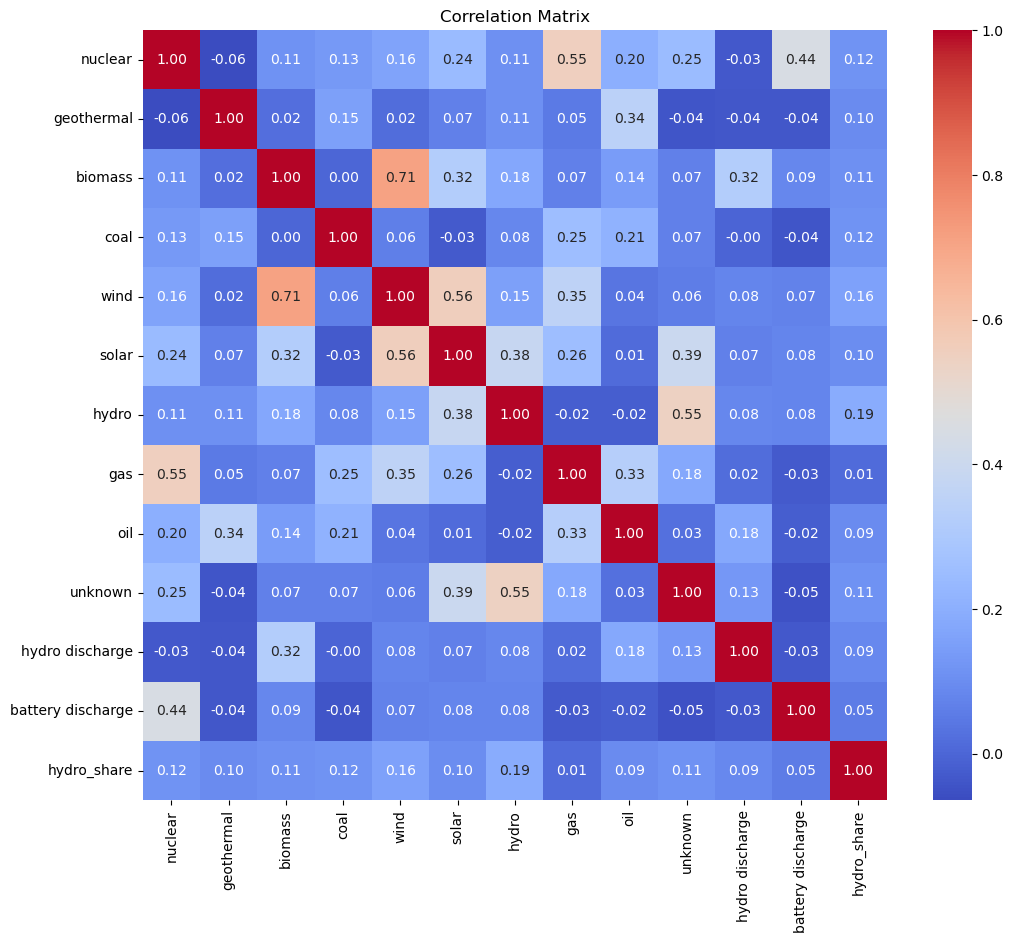

In [31]:
import seaborn as sns

columns_of_interest = ['zone', 'nuclear', 'geothermal', 'biomass', 'coal', 'wind', 'solar', 'hydro', 'gas', 'oil', 'unknown', 'hydro discharge', 'battery discharge', 'region', 'hydro_share']
selected_columns = new_consumption_df[columns_of_interest]

# Calculate correlation matrix
correlation_matrix = selected_columns.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Basically, I can't find any two valuable variables to further analyze the correlations. 

The next step is to drop nan values under 'CarbonIntensity' column in df_intensity 

In [32]:
column = 'carbonIntensity'
df_intensity_valuable = df_intensity.dropna(subset=[column])
df_intensity_valuable

,zone,carbonIntensity,datetime,updatedAt,createdAt,emissionFactorType,isEstimated,estimationMethod
0,AT,63,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
1,AU-NSW,633,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
2,AU-NT,488,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
3,AU-QLD,709,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
4,AU-SA,388,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
...,...,...,...,...,...,...,...,...
141,US-SW-WALC,239,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE
142,US-TEN-TVA,357,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,lifecycle,True,TIME_SLICER_AVERAGE
143,US-TEX-ERCO,349,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
144,UY,43,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE


In the followings, I concat new_consumption_df and df_intensity_valuable, aiming to investigate the relationship between hydro and carbon intensity values. 

In [33]:
a_df=pd.concat([new_consumption_df,df_intensity_valuable],axis=1)
a_df

,zone,nuclear,geothermal,biomass,coal,wind,solar,hydro,gas,oil,...,hydro_share,wind_share,zone,carbonIntensity,datetime,updatedAt,createdAt,emissionFactorType,isEstimated,estimationMethod
0,AT,0,0,301,0,500,690,3746,72,0,...,1,1,AT,63,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
1,AU-NSW,0,0,35,5471,1318,0,306,32,0,...,1,1,AU-NSW,633,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
2,AU-NT,0,0,1,0,0,0,0,144,0,...,0,0,AU-NT,488,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
3,AU-QLD,0,0,20,4742,641,0,79,68,0,...,1,1,AU-QLD,709,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
4,AU-SA,0,0,0,424,579,0,11,405,0,...,1,1,AU-SA,388,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,US-SW-WALC,0,0,0,0,12,120,530,495,0,...,1,1,US-SW-WALC,239,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE
142,US-TEN-TVA,7286,0,0,2333,15,551,1050,6652,9,...,1,1,US-TEN-TVA,357,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,lifecycle,True,TIME_SLICER_AVERAGE
143,US-TEX-ERCO,3688,0,0,5199,9257,10413,107,24280,0,...,1,1,US-TEX-ERCO,349,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
144,UY,0,0,157,0,346,205,1038,0,0,...,1,1,UY,43,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE


In [34]:
# Check how many zones have value 1 for hydro_share and see the implementability of running linear regression
a_df["hydro_share"].sum()

122

In [35]:
#Select zones with hydro value 
a_df_1=a_df[a_df["hydro_share"]==1]
a_df_1

,zone,nuclear,geothermal,biomass,coal,wind,solar,hydro,gas,oil,...,hydro_share,wind_share,zone,carbonIntensity,datetime,updatedAt,createdAt,emissionFactorType,isEstimated,estimationMethod
0,AT,0,0,301,0,500,690,3746,72,0,...,1,1,AT,63,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
1,AU-NSW,0,0,35,5471,1318,0,306,32,0,...,1,1,AU-NSW,633,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
3,AU-QLD,0,0,20,4742,641,0,79,68,0,...,1,1,AU-QLD,709,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
4,AU-SA,0,0,0,424,579,0,11,405,0,...,1,1,AU-SA,388,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
5,AU-TAS,0,0,0,228,143,0,728,68,0,...,1,1,AU-TAS,205,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,lifecycle,True,TIME_SLICER_AVERAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,US-SW-WALC,0,0,0,0,12,120,530,495,0,...,1,1,US-SW-WALC,239,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE
142,US-TEN-TVA,7286,0,0,2333,15,551,1050,6652,9,...,1,1,US-TEN-TVA,357,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,lifecycle,True,TIME_SLICER_AVERAGE
143,US-TEX-ERCO,3688,0,0,5199,9257,10413,107,24280,0,...,1,1,US-TEX-ERCO,349,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
144,UY,0,0,157,0,346,205,1038,0,0,...,1,1,UY,43,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE


In [36]:
# Fit a linear regression model of hydro on carbon intensity

model = ols('carbonIntensity~hydro', data=a_df_1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        carbonIntensity   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     5.463
Date:                Fri, 03 May 2024   Prob (F-statistic):             0.0211
Time:                        18:58:40   Log-Likelihood:                -831.91
No. Observations:                 122   AIC:                             1668.
Df Residuals:                     120   BIC:                             1673.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    301.7183     22.410     13.464      0.000     257.348     346.089
hydro         -0.0127      0.005     -2.337      0.021      -0.023      -0.002
==============================================================================
Omnibus:                       10.113   Durbin-Watson:                   1.181
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.106
Skew:                           0.655   Prob(JB):                      0.00639
Kurtosis:                       2.478   Cond. No.                     4.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Interpretation: 

Coefficient value is -0.0127, which indicates with 1 unit of increase in hydrogen, carbonIntensity value decrease -0.0127, which is surprisingly opposite to my assumption.

In [37]:
new_df = []

for zone in new_consumption_df['zone']:
    if zone in df_intensity_valuable['zone'].values:
        df_subset = df_intensity_valuable[df_intensity_valuable['zone'] == zone]
        df = pd.concat([new_consumption_df[new_consumption_df['zone'] == zone], df_subset], axis=1)
        new_df.append(df)

new_df = pd.concat(new_df)

new_df

,zone,nuclear,geothermal,biomass,coal,wind,solar,hydro,gas,oil,...,hydro_share,wind_share,zone,carbonIntensity,datetime,updatedAt,createdAt,emissionFactorType,isEstimated,estimationMethod
0,AT,0,0,301,0,500,690,3746,72,0,...,1,1,AT,63,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
1,AU-NSW,0,0,35,5471,1318,0,306,32,0,...,1,1,AU-NSW,633,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
2,AU-NT,0,0,1,0,0,0,0,144,0,...,0,0,AU-NT,488,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
3,AU-QLD,0,0,20,4742,641,0,79,68,0,...,1,1,AU-QLD,709,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
4,AU-SA,0,0,0,424,579,0,11,405,0,...,1,1,AU-SA,388,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,US-SW-WALC,0,0,0,0,12,120,530,495,0,...,1,1,US-SW-WALC,239,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE
142,US-TEN-TVA,7286,0,0,2333,15,551,1050,6652,9,...,1,1,US-TEN-TVA,357,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,lifecycle,True,TIME_SLICER_AVERAGE
143,US-TEX-ERCO,3688,0,0,5199,9257,10413,107,24280,0,...,1,1,US-TEX-ERCO,349,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
144,UY,0,0,157,0,346,205,1038,0,0,...,1,1,UY,43,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE


I merged two dataframe that include powerbreakdown and carbonintensity.
For assumption, I think fossilfreepercentage and carbonintensity data have correlations, so an essential step is to drop the Nan values under these two columns.

In [38]:
Merged_df=pd.concat([data,df_intensity],axis=1)
Merged_df

,zone,datetime,updatedAt,createdAt,fossilFreePercentage,renewablePercentage,powerConsumptionTotal,powerProductionTotal,powerImportTotal,powerExportTotal,...,powerImportBreakdown.MX-NE,powerExportBreakdown.MX-NE,zone,carbonIntensity,datetime,updatedAt,createdAt,emissionFactorType,isEstimated,estimationMethod
0,AT,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,99,99,6183,7731,0.0,1548.0,...,NaN,NaN,AT,63,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
1,AU-NSW,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,23,23,7162,7356,466.0,658.0,...,NaN,NaN,AU-NSW,633,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
2,AU-NT,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:05.097Z,1,1,145,145,0.0,0.0,...,NaN,NaN,AU-NT,488,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
3,AU-QLD,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,13,13,5550,6036,0.0,466.0,...,NaN,NaN,AU-QLD,709,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
4,AU-SA,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,42,42,1436,839,597.0,0.0,...,NaN,NaN,AU-SA,388,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,US-SW-WALC,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:23.796Z,57,57,1156,1156,NaN,NaN,...,NaN,NaN,US-SW-WALC,239,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE
142,US-TEN-TVA,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,49,9,18209,17075,1134.0,0.0,...,NaN,NaN,US-TEN-TVA,357,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,lifecycle,True,TIME_SLICER_AVERAGE
143,US-TEX-ERCO,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,44,37,53068,53230,0.0,162.0,...,0.0,41.0,US-TEX-ERCO,349,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
144,UY,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:23.796Z,100,100,1747,1747,NaN,NaN,...,NaN,NaN,UY,43,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE


In [39]:
columns_to_check = ['fossilFreePercentage', 'carbonIntensity']
Result_df = Merged_df.dropna(subset=columns_to_check)
Result_df


,zone,datetime,updatedAt,createdAt,fossilFreePercentage,renewablePercentage,powerConsumptionTotal,powerProductionTotal,powerImportTotal,powerExportTotal,...,powerImportBreakdown.MX-NE,powerExportBreakdown.MX-NE,zone,carbonIntensity,datetime,updatedAt,createdAt,emissionFactorType,isEstimated,estimationMethod
0,AT,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,99,99,6183,7731,0.0,1548.0,...,NaN,NaN,AT,63,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
1,AU-NSW,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,23,23,7162,7356,466.0,658.0,...,NaN,NaN,AU-NSW,633,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
2,AU-NT,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:05.097Z,1,1,145,145,0.0,0.0,...,NaN,NaN,AU-NT,488,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
3,AU-QLD,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,13,13,5550,6036,0.0,466.0,...,NaN,NaN,AU-QLD,709,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
4,AU-SA,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,42,42,1436,839,597.0,0.0,...,NaN,NaN,AU-SA,388,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,lifecycle,True,TIME_SLICER_AVERAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,US-SW-WALC,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:23.796Z,57,57,1156,1156,NaN,NaN,...,NaN,NaN,US-SW-WALC,239,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE
142,US-TEN-TVA,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,49,9,18209,17075,1134.0,0.0,...,NaN,NaN,US-TEN-TVA,357,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,lifecycle,True,TIME_SLICER_AVERAGE
143,US-TEX-ERCO,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,44,37,53068,53230,0.0,162.0,...,0.0,41.0,US-TEX-ERCO,349,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,lifecycle,True,TIME_SLICER_AVERAGE
144,UY,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:23.796Z,100,100,1747,1747,NaN,NaN,...,NaN,NaN,UY,43,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:23.796Z,lifecycle,True,TIME_SLICER_AVERAGE


In [40]:
len(Result_df)

146

In [41]:
model1 = ols('carbonIntensity~fossilFreePercentage', data=Result_df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        carbonIntensity   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1302.
Date:                Fri, 03 May 2024   Prob (F-statistic):           5.25e-74
Time:                        18:58:40   Log-Likelihood:                -832.98
No. Observations:                 146   AIC:                             1670.
Df Residuals:                     144   BIC:                             1676.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              684.5698     12.009     57.003      0.000     660.832     708.307
fossilFreePercentage    -6.5633      0.182    -36.080      0.000      -6.923      -6.204
==============================================================================
Omnibus:                       29.087   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.924
Skew:                           0.874   Prob(JB):                     1.60e-13
Kurtosis:                       5.576   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Coefficient value is -6.56, which means one-unit increase in fossil-free percentage is associated with a decrease of 6.5633 units in carbon intensity.

#### Relationship between hydro_share and renewable percentage

Besides assumptions above, I also have interest in finding whether hydro_share has an impact on the renewable percentage in data. Below are the operations:

In [42]:
b_df=pd.concat([data,new_consumption_df],axis=1)
b_df

,zone,datetime,updatedAt,createdAt,fossilFreePercentage,renewablePercentage,powerConsumptionTotal,powerProductionTotal,powerImportTotal,powerExportTotal,...,solar,hydro,gas,oil,unknown,hydro discharge,battery discharge,region,hydro_share,wind_share
0,AT,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,99,99,6183,7731,0.0,1548.0,...,690,3746,72,0,18,857,0,European Union,1,1
1,AU-NSW,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,23,23,7162,7356,466.0,658.0,...,0,306,32,0,0,0,0,Australia,1,1
2,AU-NT,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:05.097Z,1,1,145,145,0.0,0.0,...,0,0,144,0,0,0,0,Australia,0,0
3,AU-QLD,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,13,13,5550,6036,0.0,466.0,...,0,79,68,0,0,0,0,Australia,1,1
4,AU-SA,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:57.239Z,42,42,1436,839,597.0,0.0,...,0,11,405,0,0,0,17,Australia,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,US-SW-WALC,2024-05-03T16:00:00.000Z,2024-05-03T15:48:36.776Z,2024-04-30T16:50:23.796Z,57,57,1156,1156,NaN,NaN,...,120,530,495,0,0,0,0,US,1,1
142,US-TEN-TVA,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:49:28.003Z,49,9,18209,17075,1134.0,0.0,...,551,1050,6652,9,313,0,0,US,1,1
143,US-TEX-ERCO,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:05.097Z,44,37,53068,53230,0.0,162.0,...,10413,107,24280,0,123,0,0,US,1,1
144,UY,2024-05-03T16:00:00.000Z,2024-05-03T16:48:28.217Z,2024-04-30T16:50:23.796Z,100,100,1747,1747,NaN,NaN,...,205,1038,0,0,0,0,0,Other Zones,1,1


In [43]:
b_df = []

for zone in new_consumption_df['zone']:
    if zone in data['zone'].values:
        df_6 = data[data['zone'] == zone]
        df = pd.concat([new_consumption_df[new_consumption_df['zone'] == zone], df_6], axis=1)
        b_df.append(df)

b_df = pd.concat(b_df)

b_df

,zone,nuclear,geothermal,biomass,coal,wind,solar,hydro,gas,oil,...,powerImportBreakdown.US-CENT-SWPP,powerExportBreakdown.US-CENT-SWPP,powerImportBreakdown.US-MIDA-PJM,powerExportBreakdown.US-MIDA-PJM,powerImportBreakdown.CA-BC,powerExportBreakdown.CA-BC,powerImportBreakdown.CA-AB,powerExportBreakdown.CA-AB,powerImportBreakdown.MX-NE,powerExportBreakdown.MX-NE
0,AT,0,0,301,0,500,690,3746,72,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AU-NSW,0,0,35,5471,1318,0,306,32,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AU-NT,0,0,1,0,0,0,0,144,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AU-QLD,0,0,20,4742,641,0,79,68,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AU-SA,0,0,0,424,579,0,11,405,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,US-SW-WALC,0,0,0,0,12,120,530,495,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,US-TEN-TVA,7286,0,0,2333,15,551,1050,6652,9,...,NaN,NaN,1134.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
143,US-TEX-ERCO,3688,0,0,5199,9257,10413,107,24280,0,...,0.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,41.0
144,UY,0,0,157,0,346,205,1038,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As shown above, we have 91 available rows, which means I can finally use regression analysis between variable "hyddro_share" and "renewablepowerpercentage"

In [44]:
'renewablePercentage' in b_df

True

In [45]:
model3 = ols('hydro_share~renewablePercentage', data=b_df).fit()

In [46]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hydro_share   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     19.64
Date:                Fri, 03 May 2024   Prob (F-statistic):           1.84e-05
Time:                        18:58:40   Log-Likelihood:                -52.914
No. Observations:                 146   AIC:                             109.8
Df Residuals:                     144   BIC:                             115.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6538      0.050     13.021      0.000       0.555       0.753
renewablePercentage     0.0037      0.001      4.432      0.000       0.002       0.005
==============================================================================
Omnibus:                       37.201   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.725
Skew:                          -1.450   Prob(JB):                     7.93e-13
Kurtosis:                       3.866   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
import numpy as np
np.sqrt(model3.scale)

0.35007271441055826

All in all, by applying the __ols estimator__ to our data, we get the __estimates:__

$$
\hat{\beta}_0 = 0.65, \quad \hat{\beta}_1=0.0037, \quad \hat{\sigma}=0.35
$$

By inserting the estimates $\hat{\beta}_0, \hat{\beta}_1$ and $\hat{\sigma}$ into our assumed linear regression model, we get the following __estimated linear regression model__ of how the incomes $Y_i$ in the data was generated:

$$
Y_i = 0.65 + 0.0037X_i + \epsilon_i
$$

where the errors $\epsilon_i$ are independent, normally distributed variables with $E(\epsilon_i)=0$ and $SD(\epsilon_i)=0.35$.


I wish to further check whether other columns have possible relationships, and wish to include more variables in my regression analysis. 

/var/folders/mg/v71tmy_j49l3vzb_w9yy3xkw0000gn/T/ipykernel_9565/4101557780.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = selected_columns.corr()


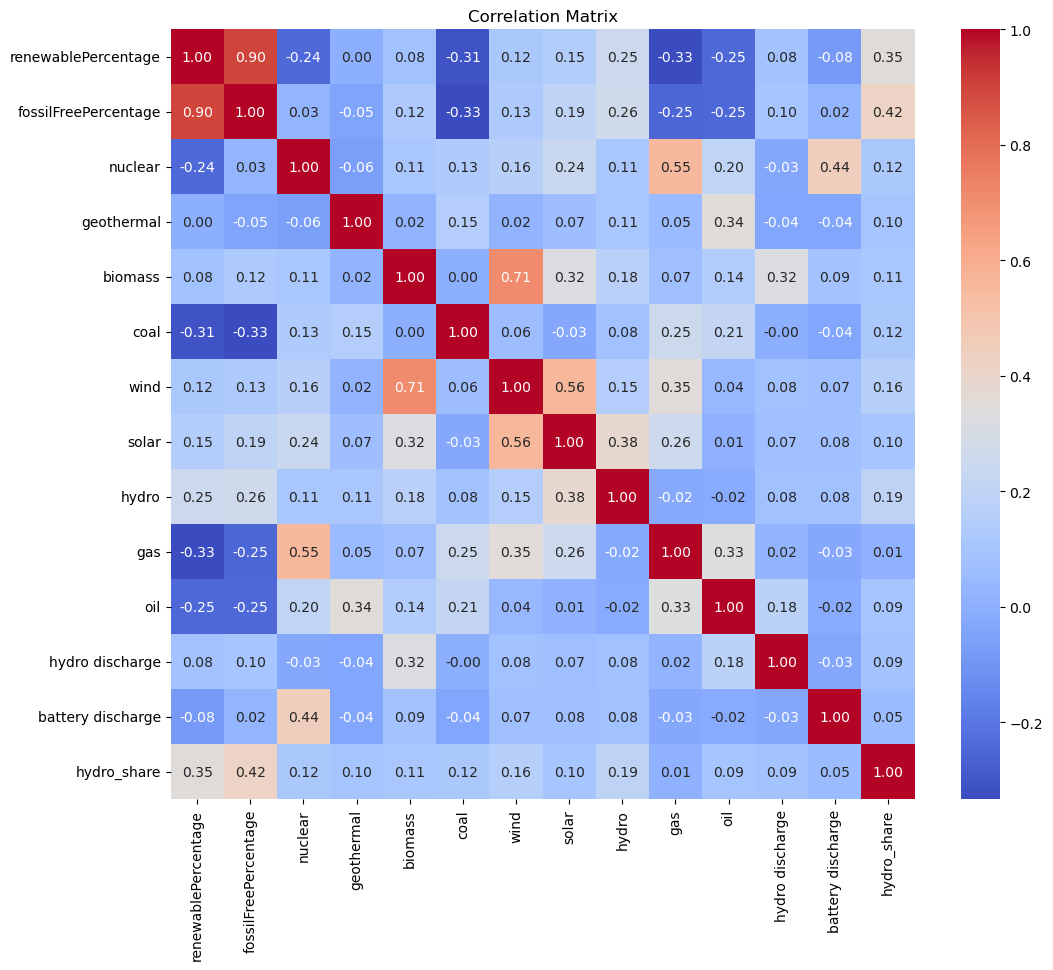

In [49]:
columns_of_interest = ['renewablePercentage','fossilFreePercentage', 'zone', 'nuclear', 'geothermal', 'biomass', 'coal', 'wind', 'solar', 'hydro', 'gas', 'oil', 'hydro discharge', 'battery discharge', 'region', 'hydro_share']
selected_columns =  b_df[columns_of_interest]

correlation_matrix = selected_columns.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Multivariable Linear Regression: wind & solar as predictors of renewablePercentage


the linear regression model:

$$
Y_i = \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \epsilon_i
$$

where the error terms $\epsilon_i$ are mean-zero normally distributed.

In [61]:
# Next, I want to analyze the relationships among renewablePercentage, wind, and solar. 

est_mod_1 = ols('renewablePercentage~wind+solar',data=b_df).fit()
est_mod_1.params

Intercept    46.714670
wind          0.000797
solar         0.001773
dtype: float64

Coefficient for wind (β1): 0.0008
Coefficient for solar (β2): 0.0018
Interpretation:

The coefficient for wind (0.0008) indicates that, holding other variables constant, a one-unit increase in Biomass is associated with an estimated increase of 0.0008 units in fossilFreePercentage.

The coefficient for solar (0.0018) indicates that, holding other variables constant, a one-unit increase in solar is associated with an estimated increase of 0.0018 units in fossilFreePercentage.

### Save all dataframes into csv files

In [62]:
b_df.to_csv('b_df.csv', index=False, header=False)
Merged_df.to_csv('Merged_df.csv', index=False, header=False)
new_df.to_csv('new_df.csv', index=False, header=False)
df_intensity_valuable.to_csv('df_intensity_valuable',index=False,header=False)
data.to_csv('data.csv',index=False,header=False)